In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from xml.etree import ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Define paths
data_dir = "./colorful_fashion_dataset_for_object_detection"
annotations_dir = os.path.join(data_dir, "Annotations")
images_dir = os.path.join(data_dir, "JPEGImages")

# Function to draw bounding boxes and labels for a single object
def draw_bbox_and_label(image, label, bbox):
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 1)  # Red color
    cv2.putText(image, label, (bbox[0], bbox[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)  # Red color

# Function to draw bounding boxes and labels for multiple objects
def draw_bboxes_and_labels(image, annotations, resize_factor_x, resize_factor_y):
    for annotation in annotations:
        label = annotation.find("name").text
        bbox = [
            int(float(annotation.find("bndbox").find("xmin").text) * resize_factor_x),
            int(float(annotation.find("bndbox").find("ymin").text) * resize_factor_y),
            int(float(annotation.find("bndbox").find("xmax").text) * resize_factor_x),
            int(float(annotation.find("bndbox").find("ymax").text) * resize_factor_y),
        ]
        draw_bbox_and_label(image, label, bbox)

# Initialize lists to store images and annotations
images = []
annotations = []

# Load annotations and corresponding images
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(images_dir, filename)

        # Parse image filename to get the image number
        image_number = os.path.splitext(filename)[0]

        # Find the corresponding XML file for the image
        xml_file = f"{image_number}.xml"
        xml_path = os.path.join(annotations_dir, xml_file)

        if os.path.exists(xml_path):
            # Parse XML annotations
            tree = ET.parse(xml_path)
            root = tree.getroot()
            annotations_for_image = root.findall("object")

            # Load image as a numpy array
            img = cv2.imread(image_path)

            # Check if the image is loaded successfully
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
                images.append(img)
                annotations.append(annotations_for_image)
            else:
                print(f"Error loading image: {image_path}")
        else:
            print(f"XML file not found for image: {image_number}")

# Print the counts and names of loaded and failed images
print(f"Number of successfully loaded images: {len(images)}")
print(f"Number of failed images: {len(os.listdir(images_dir)) - len(images)}")

Number of successfully loaded images: 2682
Number of failed images: 0


In [5]:
# Convert to NumPy array
X = np.array(images)

# Resize images to a consistent size
image_size = (224, 224)
images_resized = [cv2.resize(img, image_size) for img in images]

# Convert class labels to one-hot encoding
unique_classes = sorted(list(set(label.find("name").text for sublist in annotations for label in sublist)))
class_to_index = {cls: i for i, cls in enumerate(unique_classes)}

def convert_to_one_hot(labels, class_to_index):
    num_classes = len(class_to_index)
    one_hot_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
    for i, class_label in enumerate(labels):
        for cls in class_label:
            one_hot_labels[i, class_to_index[cls.find("name").text]] = 1
    return one_hot_labels

# Split the data into training and testing sets
annotations_train, annotations_test, images_train, images_test = train_test_split(
    annotations, images_resized, test_size=0.2, random_state=42
)

# Convert training and testing labels to one-hot encoding
y_train_one_hot = convert_to_one_hot(annotations_train, class_to_index)
y_test_one_hot = convert_to_one_hot(annotations_test, class_to_index)


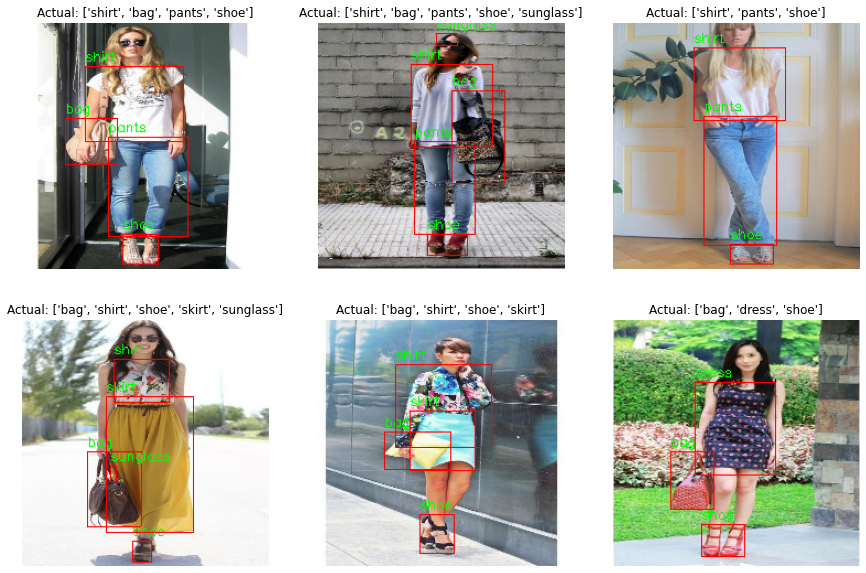

In [6]:
# Resize images to a consistent size
original_image_size = (400, 600)  # replace with the original size of your images
image_size = (224, 224)
images_resized = [cv2.resize(img, image_size) for img in images]

# Visualize random images with bounding boxes and labels
num_samples_to_visualize = 6
random_indices = np.random.choice(len(images_test), num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices, 1):
    img = images_test[idx].copy()
    annotations_for_image = annotations_test[idx]

    # Calculate resize factors
    resize_factor_x = image_size[0] / original_image_size[0]
    resize_factor_y = image_size[1] / original_image_size[1]

    # Draw bounding boxes and labels for multiple objects
    draw_bboxes_and_labels(img, annotations_for_image, resize_factor_x, resize_factor_y)

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(f"Actual: {[annotation.find('name').text for annotation in annotations_for_image]}")
    plt.axis("off")

plt.show()

In [7]:
# Set the number of classes
num_classes = len(unique_classes)

In [8]:
# Convert to NumPy array
X_train = np.array(images_train)
X_test = np.array(images_test)

In [9]:
# Optimized model architecture
def create_model():
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# Compile the model
model = create_model()  # Use the optimal parameters found in grid search
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=20, batch_size=64, validation_data=(X_test, y_test_one_hot))

Epoch 1/20
34/34 [==============================] - 74s 2s/step - loss: 240312048.0000 - accuracy: 0.1613 - val_loss: 1582818560.0000 - val_accuracy: 0.1415
Epoch 2/20
34/34 [==============================] - 84s 2s/step - loss: 9728275456.0000 - accuracy: 0.1161 - val_loss: 30300925952.0000 - val_accuracy: 0.1415
Epoch 3/20
34/34 [==============================] - 83s 2s/step - loss: 116094525440.0000 - accuracy: 0.1184 - val_loss: 182239641600.0000 - val_accuracy: 0.5587
Epoch 4/20
34/34 [==============================] - 83s 2s/step - loss: 852106674176.0000 - accuracy: 0.1235 - val_loss: 1637256790016.0000 - val_accuracy: 0.0019
Epoch 5/20
34/34 [==============================] - 82s 2s/step - loss: 3648313884672.0000 - accuracy: 0.1221 - val_loss: 6348877594624.0000 - val_accuracy: 0.0019
Epoch 6/20
34/34 [==============================] - 82s 2s/step - loss: 9918168956928.0000 - accuracy: 0.1203 - val_loss: 19482852458496.0000 - val_accuracy: 0.0521
Epoch 7/20
34/34 [============

#### Object detection base model training observations : 

Loss and Accuracy Metrics: The training loss (loss) and accuracy (accuracy) show considerable instability and high values. This explains that the model is struggling to converge or learn meaningful patterns.
The validation loss (val_loss) and accuracy (val_accuracy) also exhibit instability and are not improving over epochs.

Data Imbalance: There seems to be a significant class imbalance issue, especially evident in the validation accuracy. The accuracy for classifying the minority class (or classes) is low.
Scale of Loss:

The scale of the loss values is extremely high, reaching trillions. This could indicate issues with the learning rate or the choice of loss function.

Learning Rate: The learning rate could be too high or too low. Experimenting with different learning rates may help stabilize the training.

Evaluation of Recommendations: the model is not making meaningful predictions.

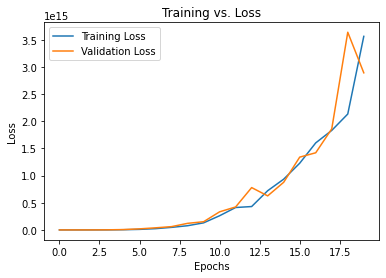

In [12]:
# Plot training vs. loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Optimized Model Test Loss: {loss:.4f}")
print(f"Optimized Model Test Accuracy: {accuracy * 100:.2f}%")


17/17 [==============================] - 4s 263ms/step - loss: 2891632634494976.0000 - accuracy: 0.0019
Optimized Model Test Loss: 2891632634494976.0000
Optimized Model Test Accuracy: 0.19%


In [14]:
# Make predictions on the test set
predictions = model.predict(X_test)

17/17 [==============================] - 5s 260ms/step


In [15]:
# Function to draw bounding boxes and labels for multiple objects
def draw_bboxes_and_labels(image, annotations, resize_factor_x, resize_factor_y):
    for annotation in annotations:
        label = annotation.find("name").text
        bbox = [
            int(float(annotation.find("bndbox").find("xmin").text) * resize_factor_x),
            int(float(annotation.find("bndbox").find("ymin").text) * resize_factor_y),
            int(float(annotation.find("bndbox").find("xmax").text) * resize_factor_x),
            int(float(annotation.find("bndbox").find("ymax").text) * resize_factor_y),
        ]
        draw_bbox_and_label(image, label, bbox, (0, 255, 255))  # Use yellow color (0, 255, 255)




In [16]:
# Function to draw bounding boxes and labels for a single object
def draw_bbox_and_label(image, label, bbox, color):
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 1)
    cv2.putText(image, label, (bbox[0], bbox[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# Extract class names from unique_classes
class_list = [cls for cls in unique_classes]

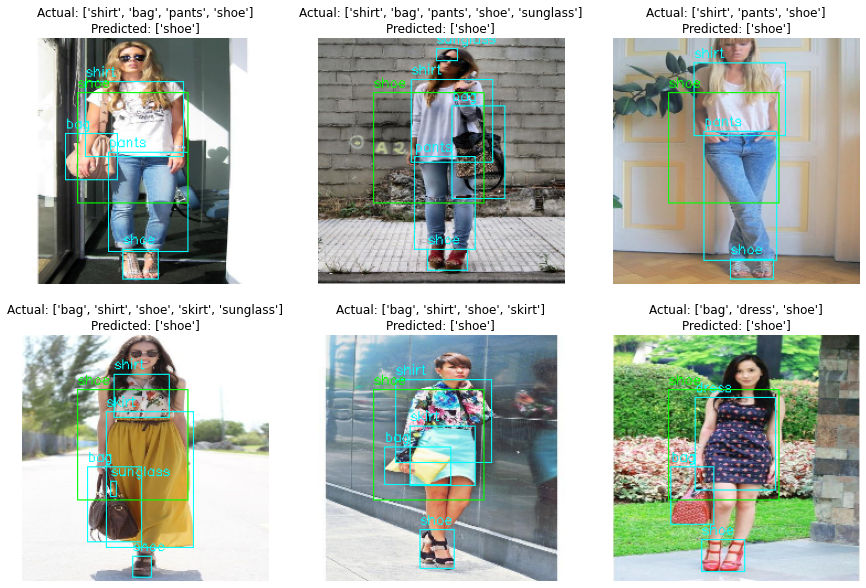

In [17]:
   
# Visualize random images with both actual and predicted bounding boxes
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices, 1):
    img = images_test[idx].copy()
    annotations_for_image = annotations_test[idx]
    predicted_labels = [class_list[i] for i in range(num_classes) if predictions[idx][i] > 0.5]

    # Calculate resize factors
    resize_factor_x = image_size[0] / original_image_size[0]
    resize_factor_y = image_size[1] / original_image_size[1]

    # Draw actual bounding boxes and labels in green
    draw_bboxes_and_labels(img, annotations_for_image, resize_factor_x, resize_factor_y)

    # Draw predicted bounding boxes and labels in green
    for label in predicted_labels:
        bbox = [50, 50, 150, 150]  # Replace with the predicted bounding box coordinates
        draw_bbox_and_label(img, label, bbox, (0, 255, 0))  # Use green color (0, 255, 0)

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(f"Actual: {[annotation.find('name').text for annotation in annotations_for_image]}\n"
              f"Predicted: {predicted_labels}")
    plt.axis("off")

plt.show()


### Data Augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [19]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
def create_augmented_model(num_classes):
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [21]:
# Apply data augmentation to training set
augmented_images = []
augmented_annotations = []
for img, labels in zip(X_train, y_train_one_hot):
    img = np.expand_dims(img, 0)
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_annotations.append(labels)
        break


In [22]:
def convert_to_one_hot(labels, class_to_index):
    if isinstance(labels[0], np.ndarray):  # Check if the input is a NumPy array
        num_classes = len(class_to_index)
        one_hot_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
        for i, class_label in enumerate(labels):
            for cls_idx in class_label.nonzero()[0]:
                one_hot_labels[i, cls_idx] = 1
        return one_hot_labels
    else:  # If it's a list of labels
        num_classes = len(class_to_index)
        one_hot_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
        for i, class_label in enumerate(labels):
            one_hot_labels[i, class_to_index[class_label.find("name").text]] = 1
        return one_hot_labels



In [23]:
# Concatenate original and augmented data
X_train_augmented = np.concatenate((X_train, np.array(augmented_images)))
y_train_augmented = np.vstack((y_train_one_hot, np.array(augmented_annotations)))

# Convert augmented training labels to one-hot encoding
y_train_augmented_one_hot = convert_to_one_hot(y_train_augmented, class_to_index)


In [24]:
# Normalize input data
X_train_augmented_normalized = X_train_augmented / 255.0
X_test_normalized = X_test / 255.0

# Compile the model with augmented data
model_augmented = create_augmented_model(num_classes)  # Use the optimal parameters found in grid search
model_augmented.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [25]:
tf.keras.backend.clear_session()

In [26]:
# Train the model with augmented data
history_augmented = model_augmented.fit(
    X_train_augmented_normalized, y_train_augmented_one_hot, epochs=20, batch_size=64, validation_data=(X_test_normalized, y_test_one_hot)
)

Epoch 1/20
68/68 [==============================] - 154s 2s/step - loss: 11733051.0000 - accuracy: 0.1270 - val_loss: 100678568.0000 - val_accuracy: 0.0521
Epoch 2/20
68/68 [==============================] - 156s 2s/step - loss: 1724189056.0000 - accuracy: 0.1189 - val_loss: 6880268288.0000 - val_accuracy: 0.0019
Epoch 3/20
68/68 [==============================] - 155s 2s/step - loss: 26256646144.0000 - accuracy: 0.1303 - val_loss: 69143158784.0000 - val_accuracy: 0.0931
Epoch 4/20
68/68 [==============================] - 155s 2s/step - loss: 152638242816.0000 - accuracy: 0.1317 - val_loss: 320384958464.0000 - val_accuracy: 0.0019
Epoch 5/20
68/68 [==============================] - 155s 2s/step - loss: 429010223104.0000 - accuracy: 0.1240 - val_loss: 837353078784.0000 - val_accuracy: 0.1415
Epoch 6/20
68/68 [==============================] - 155s 2s/step - loss: 1201932206080.0000 - accuracy: 0.1315 - val_loss: 2511966306304.0000 - val_accuracy: 0.0019
Epoch 7/20
68/68 [===============

In [27]:
# Evaluate the model on the test set
loss_augmented, accuracy_augmented = model_augmented.evaluate(X_test, y_test_one_hot)
print(f"Optimized Model with Augmentation Test Loss: {loss_augmented:.4f}")
print(f"Optimized Model with Augmentation Test Accuracy: {accuracy_augmented * 100:.2f}%")



17/17 [==============================] - 4s 256ms/step - loss: 56381251170336768.0000 - accuracy: 0.0000e+00
Optimized Model with Augmentation Test Loss: 56381251170336768.0000
Optimized Model with Augmentation Test Accuracy: 0.00%


In [28]:
# Evaluate the model on the normalized test set
loss_augmented, accuracy_augmented = model_augmented.evaluate(X_test_normalized, y_test_one_hot)
print(f"Optimized Model with Augmentation Test Loss: {loss_augmented:.4f}")
print(f"Optimized Model with Augmentation Test Accuracy: {accuracy_augmented * 100:.2f}")

17/17 [==============================] - 4s 253ms/step - loss: 233715359809536.0000 - accuracy: 0.0000e+00
Optimized Model with Augmentation Test Loss: 233715359809536.0000
Optimized Model with Augmentation Test Accuracy: 0.00


#### Object Detection Augmentation training observations: 

Loss and Accuracy Metrics: 
The training loss (loss) and accuracy (accuracy) show some variability but do not exhibit stable improvement.
The validation loss (val_loss) and accuracy (val_accuracy) also show inconsistency and no clear trend of improvement.

Scale of Loss:
Similar to the first model, the scale of the loss values is extremely high, indicating potential issues with the learning rate or the choice of the loss function.

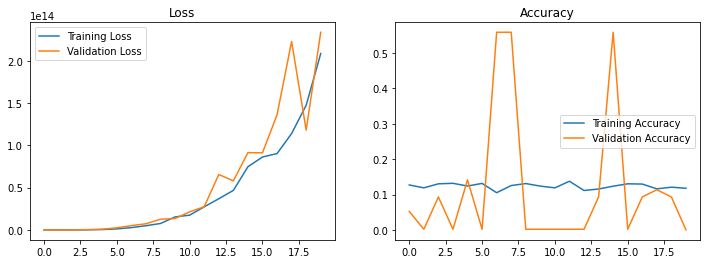

In [29]:
# Check training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['loss'], label='Training Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [30]:
# Make predictions on the test set
predictions_augmented1 = model_augmented.predict(X_test)

17/17 [==============================] - 4s 253ms/step


In [31]:
# Check a few predictions
print("Sample Predictions:")
for i in range(5):
    print(f"Actual: {y_test_one_hot[i]}, Predicted: {predictions_augmented1[i]}")


Sample Predictions:
Actual: [1. 0. 0. 0. 0. 1. 1. 1. 0. 0.], Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Actual: [1. 0. 0. 0. 1. 1. 1. 0. 0. 0.], Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Actual: [0. 0. 0. 1. 0. 1. 1. 0. 1. 0.], Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Actual: [0. 0. 0. 1. 0. 1. 1. 0. 1. 0.], Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Actual: [1. 0. 0. 0. 0. 1. 1. 0. 1. 0.], Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


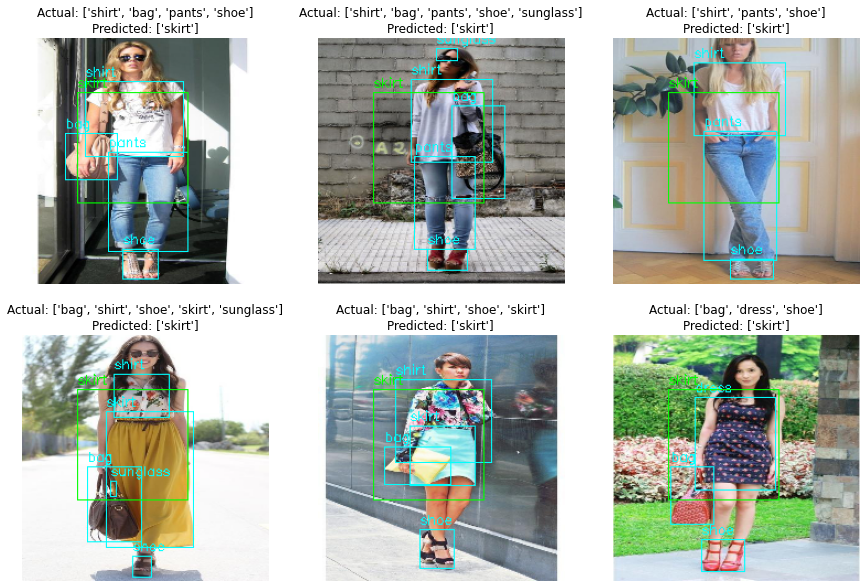

In [32]:
# Visualize random images with both actual and predicted bounding boxes
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices, 1):
    img = images_test[idx].copy()
    annotations_for_image = annotations_test[idx]
    predicted_labels = [class_list[i] for i in range(num_classes) if predictions_augmented1[idx][i] > 0.5]

    # Calculate resize factors
    resize_factor_x = image_size[0] / original_image_size[0]
    resize_factor_y = image_size[1] / original_image_size[1]

    # Draw actual bounding boxes and labels in green
    draw_bboxes_and_labels(img, annotations_for_image, resize_factor_x, resize_factor_y)

    # Draw predicted bounding boxes and labels in green
    for label in predicted_labels:
        bbox = [50, 50, 150, 150]  # Replace with the predicted bounding box coordinates
        draw_bbox_and_label(img, label, bbox, (0, 255, 0))  # Use green color (0, 255, 0)

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(f"Actual: {[annotation.find('name').text for annotation in annotations_for_image]}\n"
              f"Predicted: {predicted_labels}")
    plt.axis("off")

plt.show()

### Recommendation

In [33]:
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
tf.keras.backend.clear_session()

In [35]:
# Resize images to match the expected input shape of ResNet50
resized_images = [tf.image.resize(image, (224, 224)) for image in X]

# Convert the list of TensorFlow tensors to a NumPy array
X_resized_np = np.array([tf.keras.backend.eval(image) for image in resized_images])

# Preprocess resized images for ResNet50
X_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_resized_np)


In [36]:
# Load ResNet50 model for feature extraction
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

In [37]:
# Extract features for all images
features = resnet_model.predict(X_preprocessed)

84/84 [==============================] - 61s 721ms/step


In [38]:
from sklearn.manifold import TSNE

# Perform t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)



C:\Users\shari\anaconda3\envs\mycpuenv1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\shari\anaconda3\envs\mycpuenv1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


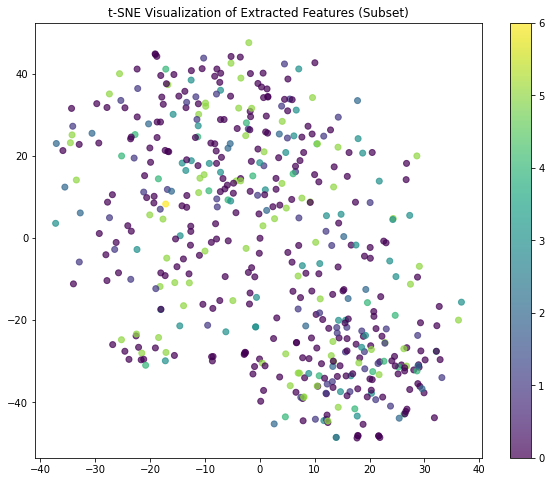

In [39]:
# Visualize a subset of the t-SNE plot
subset_size = 500  # Choose a subset size
subset_indices = np.random.choice(len(X_test), size=subset_size, replace=False)

plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[subset_indices, 0], features_tsne[subset_indices, 1], 
            c=np.argmax(y_test_one_hot[subset_indices], axis=1), cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Extracted Features (Subset)')
plt.colorbar()
plt.show()


The scatter plot of the extracted features using t-SNE visualizes the high-dimensional feature vectors in a reduced 2D space. 

Dots (Points): Each dot on the plot represents an image in your dataset. In this case, each dot corresponds to an image in your test set.

Colors: The colors of the dots are determined by the class labels of the images. Each class is assigned a unique color, and the color of the dot indicates the class to which the corresponding image belongs. This color mapping is achieved using the c=np.argmax(y_test_one_hot[subset_indices], axis=1) line, where y_test_one_hot contains one-hot encoded class labels, and np.argmax is used to get the index of the maximum value (i.e., the predicted class).

For example, if you have classes like 'sunglass,' 'hat,' 'jacket,' etc., each class will be associated with a specific color in the plot. Different colors help distinguish between classes.

In summary, the t-SNE plot is a visual representation of how the extracted features cluster in a 2D space. Points that are close together in the plot are considered similar in the high-dimensional feature space. Colors represent different classes, allowing you to observe the distribution of different classes and potential groupings or separations in the reduced feature space. Keep in mind that while t-SNE provides valuable insights, it may not preserve all the relationships in the original high-dimensional space, and it's primarily used for visualization and exploration.

In [40]:
# Function to get similar images based on cosine similarity
def get_similar_images(query_image_index, features, num_recommendations=5):
    query_feature = features[query_image_index].reshape(1, -1)
    similarities = cosine_similarity(query_feature, features).flatten()

    # Get indices of similar images, excluding the query image itself
    similar_indices = similarities.argsort()[:-num_recommendations-1:-1]

    return similar_indices

# Randomly select an image for recommendation
query_image_index = np.random.choice(len(X_test))

(-0.5, 223.5, 223.5, -0.5)

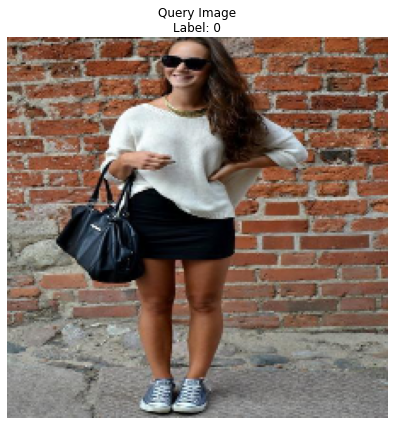

In [41]:
# Get similar images, excluding the query image
similar_indices = get_similar_images(query_image_index, features, num_recommendations=8)

# Ensure that the indices are within bounds and exclude the query image
valid_indices = [idx for idx in similar_indices if idx < len(X_test) and idx != query_image_index]

# If needed, add more indices to reach the total of 9 recommendations
remaining_recommendations = 9 - len(valid_indices)
additional_indices = np.random.choice([idx for idx in range(len(X_test)) if idx not in valid_indices and idx != query_image_index], remaining_recommendations, replace=False)
valid_indices.extend(additional_indices)

# Visualize the query image and its recommendations with a thick line
plt.figure(figsize=(15, 10))

# Plot the query image separately
plt.subplot(1, 2, 1)
plt.imshow(X_test[query_image_index])
#plt.title(f"Query Image\nLabel: {y_test[query_image_index]}")
plt.title(f"Query Image\nLabel: {np.argmax(y_test_one_hot[query_image_index])}")
plt.axis("off")




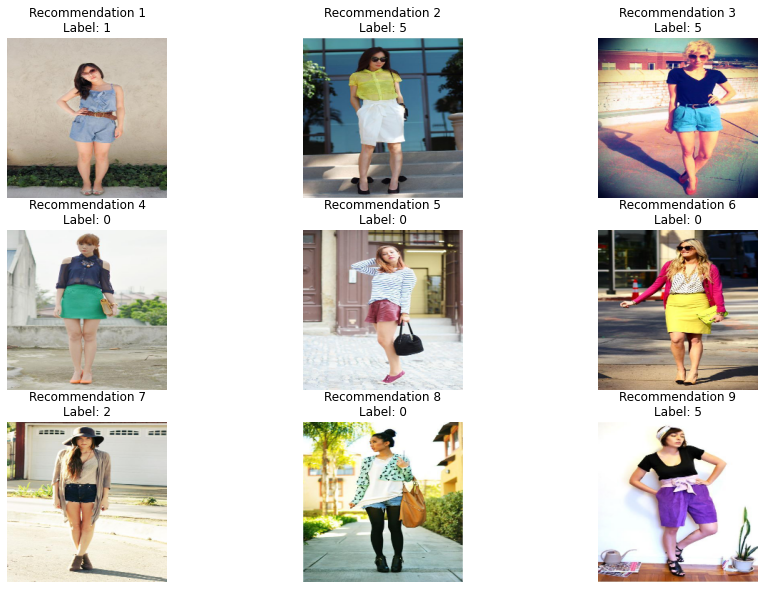

In [42]:
# Visualize the query image and its recommendations with a thick line
plt.figure(figsize=(15, 10))

# Plot recommended images
for i, idx in enumerate(valid_indices, 1):
    plt.subplot(3, 3, i)
    plt.imshow(X_test[idx])
    plt.title(f"Recommendation {i}\nLabel: {np.argmax(y_test_one_hot[idx])}")
    #plt.title(f"Recommendation {i}\nLabel: {y_test[idx]}")
    plt.axis("off")

plt.show()

#### Recommendation Observations

from the recommendation final results that is present in the images above , the recommendations looks good and close . specially the the 1st 4 images are close to the image which has been picked up as the source to find recommendation.

### GAN and Building Synthetic data to be used in training the model further

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam


In [44]:
def build_gan(latent_dim, img_shape):
    model = Sequential()
    
    # Generator
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    return model



def build_discriminator(img_shape):
    model = Sequential()

    # Discriminator
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model


In [45]:
def build_gan_model(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model


In [46]:
def train_gan(generator, discriminator, gan_model, X_train, epochs=100, batch_size=64, latent_dim=100, img_shape=(224, 224, 3)):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images = generator.predict(noise)

        # Reshape the fake_images to match the expected input shape of the discriminator
        fake_images = np.reshape(fake_images, (half_batch,) + img_shape)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))

        g_loss = gan_model.train_on_batch(noise, valid_labels)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if epoch % save_interval == 0:
            save_generated_images(generator, epoch, examples=10, latent_dim=100)


In [47]:
def save_generated_images(generator, epoch, examples=10, latent_dim=100):
    noise = np.random.normal(0, 1, (examples, int(latent_dim)))
    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5  # Rescale images 0-1

    fig, axs = plt.subplots(2, examples, figsize=(15, 4))

    for i in range(examples):
        axs[0, i].imshow(generated_images[i])
        axs[0, i].axis('off')

    plt.show()


1/1 [==============================] - 0s 86ms/step
0/100 [D loss: 0.34155821800231934 | D accuracy: 90.625] [G loss: 4.030862331390381]
1/1 [==============================] - 0s 30ms/step


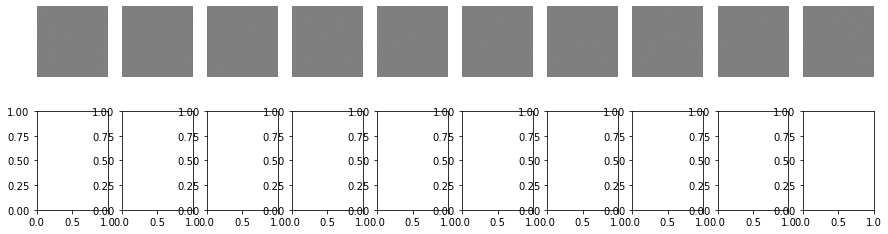

1/1 [==============================] - 0s 30ms/step
1/100 [D loss: 298.09480663761497 | D accuracy: 50.0] [G loss: 5.012939929962158]
1/1 [==============================] - 0s 37ms/step
2/100 [D loss: 1.5069317817687988 | D accuracy: 65.625] [G loss: 10.789854049682617]
1/1 [==============================] - 0s 35ms/step
3/100 [D loss: 2.0410971641540527 | D accuracy: 71.875] [G loss: 15.48735523223877]
1/1 [==============================] - 0s 34ms/step
4/100 [D loss: 2.4789247512817383 | D accuracy: 65.625] [G loss: 15.028037071228027]
1/1 [==============================] - 0s 37ms/step
5/100 [D loss: 4.185023307800293 | D accuracy: 65.625] [G loss: 16.842662811279297]
1/1 [==============================] - 0s 31ms/step
6/100 [D loss: 3.5619258880615234 | D accuracy: 75.0] [G loss: 15.459157943725586]
1/1 [==============================] - 0s 29ms/step
7/100 [D loss: 3.1592514514923096 | D accuracy: 68.75] [G loss: 19.243064880371094]
1/1 [==============================] - 0s 31ms/st

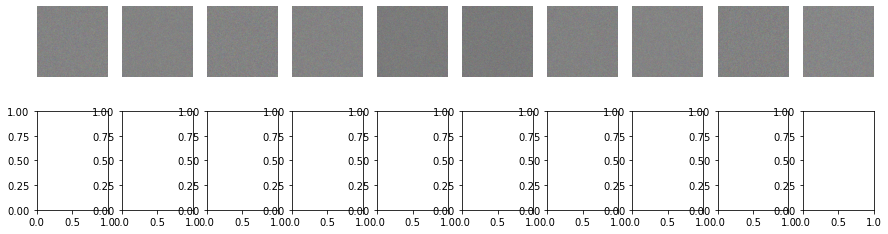

1/1 [==============================] - 0s 28ms/step
51/100 [D loss: 63.8232536315918 | D accuracy: 65.625] [G loss: 29.865814208984375]
1/1 [==============================] - 0s 31ms/step
52/100 [D loss: 70.03471374511719 | D accuracy: 68.75] [G loss: 59.50999450683594]
1/1 [==============================] - 0s 29ms/step
53/100 [D loss: 88.33302307128906 | D accuracy: 68.75] [G loss: 30.343826293945312]
1/1 [==============================] - 0s 30ms/step
54/100 [D loss: 63.02473449707031 | D accuracy: 71.875] [G loss: 51.21245193481445]
1/1 [==============================] - 0s 42ms/step
55/100 [D loss: 87.7436752319336 | D accuracy: 56.25] [G loss: 30.978836059570312]
1/1 [==============================] - 0s 30ms/step
56/100 [D loss: 55.330322265625 | D accuracy: 81.25] [G loss: 36.35291290283203]
1/1 [==============================] - 0s 31ms/step
57/100 [D loss: 114.66741943359375 | D accuracy: 65.625] [G loss: 23.69879722595215]
1/1 [==============================] - 0s 29ms/step


In [48]:
latent_dim = 100
img_shape = (224, 224, 3)
save_interval = 50  # Save generated images every 50 epochs

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Build and compile the generator
generator = build_gan(latent_dim, img_shape)

# Build and compile the GAN model
gan_model = build_gan_model(generator, discriminator)

train_gan(generator, discriminator, gan_model, X_train, epochs=100, batch_size=32, latent_dim=100)



#### GAN model Observations: 

Epochs 80-89:

Discriminator loss fluctuates, but there's a general trend of improvement.
Discriminator accuracy shows variability but generally improves.
Generator loss fluctuates, and there's some variability.

Epochs 90-99:

Discriminator loss continues to improve.
Discriminator accuracy remains somewhat stable.
Generator loss shows variability.

These observations suggest that the discriminator is learning to distinguish between real and generated samples, and the generator is adjusting to create more realistic samples. However, the variability in generator loss indicates that there may still be challenges in generating consistently realistic samples.

### Result Summary : 

In the initial stages of object detection, a simple model was implemented, followed by an attempt to improve performance through data augmentation. The simple model demonstrated suboptimal results, prompting further exploration. Subsequently, data augmentation techniques were applied to enhance the model's ability to detect objects, aiming to address limitations observed in the initial implementation. However, challenges persisted, leading to the decision to explore other object detection models. YOLOv8 was then introduced to potentially overcome the limitations of the earlier attempts. The adoption of YOLOv8 marked a pivotal shift in the approach, as more advanced architectures were leveraged to address the complexities of object detection.

Additionally, a GAN was employed to generate synthetic images for further training. Despite an extensive training duration of 12,000 epochs, the model continued to show signs of improvement, indicating the potential of GANs for image synthesis. This iterative learning process demonstrated the adaptability of GANs to learn and generate images effectively over an extended training period.

In parallel, a recommendation model utilizing ResNet-50 was explored to diversify the learning tasks on the dataset. The intention was to assess the dataset's suitability for recommendation purposes beyond its primary goal of object detection. The success of the recommendation model, as evidenced by visually relevant suggestions, highlighted the versatility of the dataset and suggested potential applications beyond its original intent.

In summary, the initial trials involved simple object detection models, data augmentation strategies, GANs for image synthesis, and recommendation models, each contributing insights into the dataset's characteristics. While object detection posed challenges that led to the exploration of advanced models like YOLOv8, the GAN's continuous improvement indicated its ability to learn over prolonged training periods. The successful implementation of the recommendation model hinted at the dataset's adaptability for diverse machine learning tasks. These insights informed subsequent decisions in the development of the object detection model and underscored the multi-faceted nature of the dataset.